# 目的
キックスタータープロジェクトが、成功するのか失敗するのか予想するモデル作成を目的とする。

精度は考えない。

データは、ks-projects-201801.csv

目的変数は、state

予想するのは、0:failed もしくは 1:successful の２値のみで、その他は無視する

## ライブラリ・データのインポート

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [2]:
df = pd.read_csv("ks-projects-201801.csv", parse_dates=True)

## データの説明
なぜか右寄せになってしまう

| 列名 | 説明 |
| :--- | :--- |
| ID | 内部ID |
| name | プロジェクト名 |
| category | サブカテゴリ |
| main_category | メインカテゴリ |
| currency | 通貨 |
| deadline | 期限 |
| goal | 目標金額 (currency単位) |
| launched | 発売日 |
| pledged | 実際に集まった額 | 
| state | プロジェクトの現状 |
| backers | パトロンの人数 |
| country | 国 |
| usd pledged | US＄で集まった額 |
| usd_pledged_real | US＄換算のpledged？ |
| usd_goal_real | US＄換算のgoal？ |

In [3]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [5]:
df.describe(include='all')

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,378657,378661,378661,378661,378661,3.786610e+05,378661,3.786610e+05,378661,378661.000000,378661,3.748640e+05,3.786610e+05,3.786610e+05
unique,NaN,375764,159,15,14,3164,NaN,378089,NaN,6,NaN,23,NaN,NaN,NaN
top,NaN,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,NaN,1970-01-01 01:00:00,NaN,failed,NaN,US,NaN,NaN,NaN
freq,NaN,41,22314,63585,295365,705,NaN,7,NaN,197719,NaN,292627,NaN,NaN,NaN
mean,1.074731e+09,NaN,NaN,NaN,NaN,NaN,4.908079e+04,NaN,9.682979e+03,NaN,105.617476,NaN,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,NaN,NaN,NaN,NaN,NaN,1.183391e+06,NaN,9.563601e+04,NaN,907.185035,NaN,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,NaN,NaN,NaN,NaN,NaN,1.000000e-02,NaN,0.000000e+00,NaN,0.000000,NaN,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,NaN,NaN,NaN,NaN,NaN,2.000000e+03,NaN,3.000000e+01,NaN,2.000000,NaN,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,NaN,NaN,NaN,NaN,NaN,5.200000e+03,NaN,6.200000e+02,NaN,12.000000,NaN,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,NaN,NaN,NaN,NaN,NaN,1.600000e+04,NaN,4.076000e+03,NaN,56.000000,NaN,3.034090e+03,4.050000e+03,1.550000e+04


## state

本来は、全 378,661 件中 46,986 件はその他に分類されるはずなので、精度は最大でも 87.6% 程度となる

今回は、残り 331,675 件のデータを前提として考える。

この時、全て failed と予想するモデルを考えると、Accuracy(正解率)は 59.6% となる

どうせモデルを作るのなら、この正解率を超えるモデルを作成できると嬉しい

In [6]:
# successful, failed, その他の件数
df.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

## state2
state2 列に 0:failed もしくは 1:successful を代入する

In [7]:
# failed or successful のみとする
df2 = df.copy()[(df.state == "failed") | (df.state == "successful")]

# state2 = 0:faled, 1:successful
df2["state2"] = 0
df2.loc[df2.state == "successful", "state2"] = 1

## name2
name2 は name の文字数

「name2」と「state2の平均」の散布図を見ると、文字数が多いほうが successful となりやすいようだ

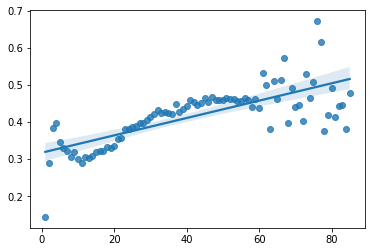

In [8]:
df2["name2"] = df2.name.str.len()
z = df2.groupby('name2').state2.mean()
sns.regplot(z.index.array, z.values)

## name3
name3 は name のスペースの数

英文はスペース区切りなので、通常は「スペースの数＋１＝単語数」となるはず

「name3」と「state2の平均」の散布図を見ると、5～15単語だと successful となりやすいようだ

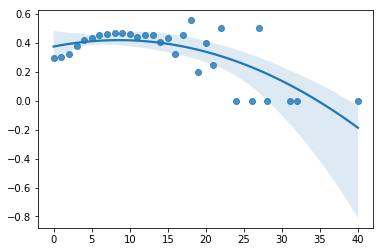

In [9]:
df2["name3"] = df2.name.str.count(" ")
z = df2.groupby('name3').state2.mean()
sns.regplot(z.index.array, z.values, order=2, truncate=True)

## category

サブカテゴリに関して、「件数」と「state2の平均」の散布図である

successful のなりやすさは、件数が増えると平均値に収束するわけではなく、サブカテゴリによって異なるようだ

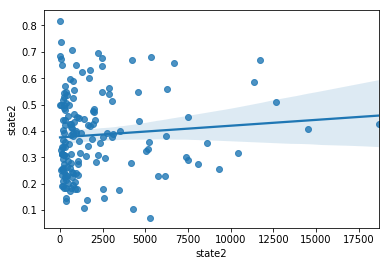

In [10]:
z = df2.groupby('category').state2
sns.regplot(z.count(), z.mean())

## main_category

メインカテゴリに関して、「件数」と「state2の平均」の表である

successful のなりやすさは、件数が増えると平均値に収束するわけではなく、メインカテゴリによって異なるようだ

In [11]:
df2.groupby('main_category').state2.describe()[["count","mean"]]

,count,mean
main_category,,
Art,25641.0,0.448890
Comics,9878.0,0.591415
Crafts,7818.0,0.270530
Dance,3573.0,0.654352
Design,25364.0,0.415944
Fashion,19775.0,0.282832
Film & Video,56527.0,0.417906
Food,22054.0,0.275914
Games,28521.0,0.438905


## currency

通貨に関して、「件数」と「state2の平均」の表である

successful のなりやすさは、件数が増えると平均値に収束するわけではなく、通貨によって異なるようだ

In [12]:
df2.groupby('currency').state2.describe()[["count","mean"]]

,count,mean
currency,,
AUD,6621.0,0.303731
CAD,12375.0,0.334303
CHF,652.0,0.286810
DKK,929.0,0.389666
EUR,14378.0,0.269996
GBP,29476.0,0.409859
HKD,477.0,0.452830
JPY,23.0,0.304348
MXN,1411.0,0.280652


## launched と deadline の year
「launchedの年」と「state2の平均」の散布図＝青色

「deadlineの年」と「state2の平均」の散布図＝赤色

年を追うごとに failed になりやすくなっている

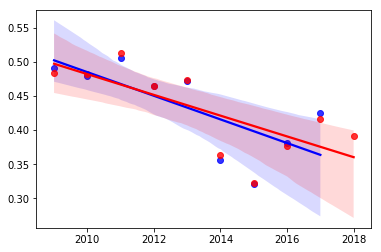

In [13]:
df2["launched2"] = pd.to_datetime(df2.launched).map(pd.Timestamp.timestamp)
df2["deadline2"] = pd.to_datetime(df2.deadline).map(pd.Timestamp.timestamp)

df2["t"] = pd.to_datetime(df2.launched).dt.year
z = df2.groupby("t").state2.mean()
sns.regplot(z.index.array, z.values, color="blue")

df2["t"] = pd.to_datetime(df2.deadline).dt.year
z = df2.groupby("t").state2.mean()
sns.regplot(z.index.array, z.values, color="red")

In [14]:
df2["year"] = pd.to_datetime(df2.launched).dt.year

## launched と deadline の month
「launchedの月」と「state2の平均」の散布図＝青色

「deadlineの月」と「state2の平均」の散布図＝赤色

春秋が successful になりやすく、夏冬は failed になりやすいようだ

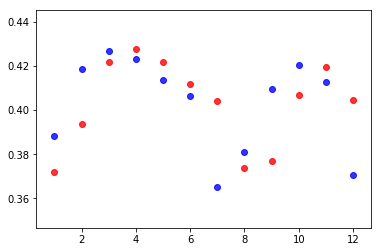

In [15]:
df2["t"] = pd.to_datetime(df2.launched).dt.month
z = df2.groupby("t").state2.mean()
sns.regplot(z.index.array, z.values, fit_reg=False, color="blue")

df2["t"] = pd.to_datetime(df2.deadline).dt.month
z = df2.groupby("t").state2.mean()
sns.regplot(z.index.array, z.values, fit_reg=False, color="red")

## launched と deadline の day

「launchedの日」と「state2の平均」の散布図＝青色

「deadlineの日」と「state2の平均」の散布図＝赤色

月初が successful になりやすく、月末は failed になりやすいようだ

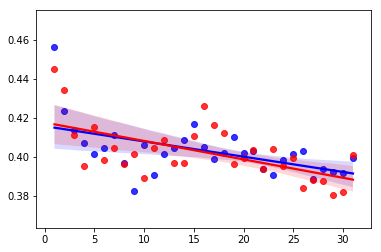

In [16]:
df2["t"] = pd.to_datetime(df2.launched).dt.day
z = df2.groupby("t").state2.mean()
sns.regplot(z.index.array, z.values, color="blue")

df2["t"] = pd.to_datetime(df2.deadline).dt.day
z = df2.groupby("t").state2.mean()
sns.regplot(z.index.array, z.values, color="red")

## deadline の dayofweek
dayofweek は deadline の曜日 (0:月曜～6:日曜)

月曜が successful になりやすく、日曜は failed になりやすいようだ

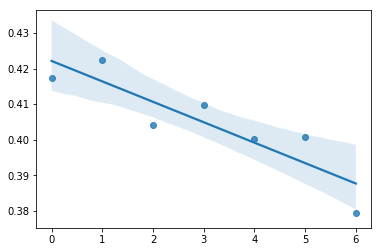

In [17]:
df2["dayofweek"] = pd.to_datetime(df2.deadline).dt.dayofweek
z = df2.groupby("dayofweek").state2.mean()
sns.regplot(z.index.array, z.values)

## days

days は deadline と launched の差 (日数)

期間が短い方が、successful となりやすいようだ

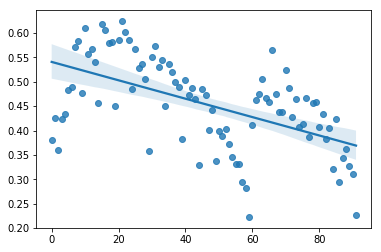

In [18]:
df2["days"] = (df2["deadline2"] - df2["launched2"]) // 86400 # 精度を秒から日に変換
z = df2.groupby("days").state2.mean()
sns.regplot(z.index.array, z.values)

## usd_goal_real の確認
「usd_goal_real」と「state2の平均」の散布図

ある一定額以上は failed になりやすいようだ

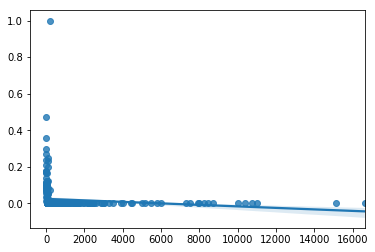

In [19]:
df2["t"] = df2.usd_goal_real // 10000
z = df2.groupby("t").state2.mean()
sns.regplot(z.index.array, z.values)

## country
国に関して、「件数」と「state2の平均」の表である

successful のなりやすさは、件数が増えると平均値に収束するわけではないと思う

In [20]:
df2.groupby('country').state2.describe()[["count","mean"]]

,count,mean
country,,
AT,485.0,0.220619
AU,6616.0,0.303809
BE,523.0,0.290631
CA,12370.0,0.334196
CH,652.0,0.286810
DE,3436.0,0.272701
DK,926.0,0.388769
ES,1873.0,0.262680
FR,2520.0,0.360317


## 欠損値の対応
今回は欠損値が少ないので、dropで対応する

In [21]:
df2.isnull().sum()

ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
state2                0
name2                 3
name3                 3
launched2             0
deadline2             0
t                     0
year                  0
dayofweek             0
days                  0
dtype: int64

In [22]:
df2 = df2.dropna()

## 学習
今回は name2, usd_goal_real, days, dayofweek, year を説明変数、state2 を目的変数として、学習を行う

他の変数も精度向上には役立ちそうだが、学習時間が増えるので、今回は採用しない

In [23]:
y = df2["state2"].values
X = df2[["name2", "usd_goal_real", "days", "dayofweek", "year"]]
clf = SGDClassifier(loss='log', penalty='none', max_iter=1000, tol=1e-3)
clf.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

## 識別精度を確認

In [24]:
y_est = clf.predict(X)
pd.DataFrame(confusion_matrix(y, y_est), 
             index=['正解 = failed', '正解 = successful'], 
             columns=['予測 = failed', '予測 = successful'])

,予測 = failed,予測 = successful
正解 = failed,105265,92346
正解 = successful,42958,90893


In [25]:
precision, recall, _, _ = precision_recall_fscore_support(y, y_est)
#print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))

正答率 = 59.180%
適合率 = 71.018%
再現率 = 53.269%
